In [5]:
import os
import numpy as np
import torch
import torch.nn.functional as F
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.models.segmentation import deeplabv3_resnet50
from google.colab import drive
from PIL import Image

In [6]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Define paths
BASE_DIR = "/content/drive/My Drive/Clothing Segmentation"
MODEL_PATH = os.path.join(BASE_DIR, "checkpoints", "deeplabv3_best.pth")
TEST_IMAGES_DIR = os.path.join(BASE_DIR, "dataset", "test", "images")
TEST_MASKS_DIR = os.path.join(BASE_DIR, "dataset", "test", "masks")
LABELS_CSV_PATH = os.path.join(BASE_DIR, "dataset", "labels.csv")

In [8]:
# Load class labels
if os.path.exists(LABELS_CSV_PATH):
    class_df = pd.read_csv(LABELS_CSV_PATH)
    class_names = class_df['label_list'].tolist()
else:
    class_names = [f"Class_{i}" for i in range(59)]  # Default for 59 classes

In [9]:
NUM_CLASSES = len(class_names)
print(f"Number of classes detected: {NUM_CLASSES}")

# Load PyTorch DeepLabV3+ model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = deeplabv3_resnet50(num_classes=NUM_CLASSES, aux_loss=True)

# Load the checkpoint
checkpoint = torch.load(MODEL_PATH, map_location=device)

# Remove auxiliary classifier weights from the checkpoint
filtered_checkpoint = {k: v for k, v in checkpoint.items() if "aux_classifier" not in k}

# Load the filtered state dictionary
missing_keys, unexpected_keys = model.load_state_dict(filtered_checkpoint, strict=False)
print(f"Missing keys: {missing_keys}")
print(f"Unexpected keys: {unexpected_keys}")

model.to(device)
model.eval()
print("Model successfully loaded!")

Number of classes detected: 59


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 99.2MB/s]


Missing keys: ['aux_classifier.0.weight', 'aux_classifier.1.weight', 'aux_classifier.1.bias', 'aux_classifier.1.running_mean', 'aux_classifier.1.running_var', 'aux_classifier.4.weight', 'aux_classifier.4.bias']
Unexpected keys: []
Model successfully loaded!


In [10]:
print("Before loading weights:", model.classifier[-1].out_channels)

Before loading weights: 59


In [11]:
# Preprocessing function for images
transform = transforms.Compose([
    transforms.Resize((256, 256)),   # Ensure consistency
    transforms.ToTensor(),           # Convert to PyTorch tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize
])


In [12]:
def preprocess_image(image_path):
    """Load and preprocess an input image."""
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Error loading image: {image_path}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    image = transform(image)
    return image

In [13]:
def calculate_iou(y_true, y_pred, num_classes=NUM_CLASSES):
    iou_scores = []

    # Identify which classes are present in either ground truth or prediction
    present_classes = set(np.unique(y_true)) | set(np.unique(y_pred))

    for cls in present_classes:
        if cls == 0:  # Assuming 0 is the background class, you can remove this check if needed
            continue

        intersection = np.logical_and(y_true == cls, y_pred == cls).sum()
        union = np.logical_or(y_true == cls, y_pred == cls).sum()

        iou = intersection / union if union > 0 else 0
        print(f"Class {cls}: IoU = {iou:.4f}, Intersection = {intersection}, Union = {union}")
        iou_scores.append(iou)

    mean_iou = np.mean(iou_scores) if iou_scores else 0  # Avoid empty list mean error
    print(f"Mean IoU: {mean_iou:.4f}")

    return iou_scores, mean_iou

In [14]:
def dice_coefficient(y_true, y_pred, num_classes=NUM_CLASSES, smooth=1e-6):
    dice_scores = []

    # Identify which classes are present in either ground truth or prediction
    present_classes = set(np.unique(y_true)) | set(np.unique(y_pred))

    for cls in present_classes:
        if cls == 0:  # Assuming 0 is the background class, you can remove this check if needed
            continue

        intersection = np.logical_and(y_true == cls, y_pred == cls).sum()
        true_sum = np.sum(y_true == cls)
        pred_sum = np.sum(y_pred == cls)

        denominator = true_sum + pred_sum
        dice = (2 * intersection + smooth) / (denominator + smooth) if denominator > 0 else 0  # Smoothed Dice coefficient

        dice_scores.append(dice)
        print(f"Class {cls}: Dice = {dice:.4f}, Intersection = {intersection}, True Pixels = {true_sum}, Pred Pixels = {pred_sum}")

    mean_dice = np.mean(dice_scores) if dice_scores else 0  # Avoid empty list mean error
    print(f"Mean Dice: {mean_dice:.4f}")

    return dice_scores, mean_dice

In [15]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from torchvision import transforms

def evaluate_single_image(model, image_path, mask_path, device, transform, target_size=(256, 256)):
    model.eval()

    # Load and preprocess image
    image = Image.open(image_path).convert("RGB")  # Ensure it's a PIL image
    image_tensor = transform(image).unsqueeze(0).to(device)  # Apply transformations

    # Load and preprocess mask
    mask = Image.open(mask_path).convert("L")  # Ensure grayscale
    mask = np.array(mask.resize(target_size, Image.NEAREST))

    # Predict mask
    with torch.no_grad():
        output = model(image_tensor)

        # Extract tensor if model returns an OrderedDict
        if isinstance(output, dict):
            output = output["out"]

        predicted_mask = torch.argmax(output, dim=1).squeeze().cpu().numpy()

    # Compute IoU and Dice only for present classes
    iou_scores, mean_iou = calculate_iou(mask, predicted_mask, NUM_CLASSES)
    dice_scores, mean_dice = dice_coefficient(mask, predicted_mask, NUM_CLASSES)

    # Compute Pixel Accuracy
    pixel_acc = np.mean(predicted_mask == mask)

    print(f"Evaluation for {os.path.basename(image_path)}:")
    print(f"Mean IoU: {mean_iou:.4f}")
    print(f"Mean Dice Coefficient: {mean_dice:.4f}")
    print(f"Pixel Accuracy: {pixel_acc:.4f}")

    # Display real image, real mask, and predicted mask (all in grayscale)
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis("off")
    axes[1].imshow(mask, cmap="gray")  # Ground Truth in grayscale
    axes[1].set_title("Ground Truth Mask")
    axes[1].axis("off")
    axes[2].imshow(predicted_mask, cmap="gray")  # Prediction in grayscale
    axes[2].set_title("Predicted Mask (Grayscale)")
    axes[2].axis("off")
    plt.show()

Class 2: IoU = 0.0000, Intersection = 0, Union = 534
Class 5: IoU = 0.0000, Intersection = 0, Union = 4871
Class 14: IoU = 0.0000, Intersection = 0, Union = 10681
Class 19: IoU = 0.7590, Intersection = 630, Union = 830
Class 20: IoU = 0.0000, Intersection = 0, Union = 42
Class 24: IoU = 0.0000, Intersection = 0, Union = 76
Class 33: IoU = 0.0000, Intersection = 0, Union = 644
Class 39: IoU = 0.3697, Intersection = 373, Union = 1009
Class 41: IoU = 0.6905, Intersection = 2213, Union = 3205
Class 42: IoU = 0.0000, Intersection = 0, Union = 9387
Class 51: IoU = 0.0000, Intersection = 0, Union = 137
Class 55: IoU = 0.0000, Intersection = 0, Union = 3993
Mean IoU: 0.1516
Class 2: Dice = 0.0000, Intersection = 0, True Pixels = 0, Pred Pixels = 534
Class 5: Dice = 0.0000, Intersection = 0, True Pixels = 4871, Pred Pixels = 0
Class 14: Dice = 0.0000, Intersection = 0, True Pixels = 0, Pred Pixels = 10681
Class 19: Dice = 0.8630, Intersection = 630, True Pixels = 772, Pred Pixels = 688
Class 20

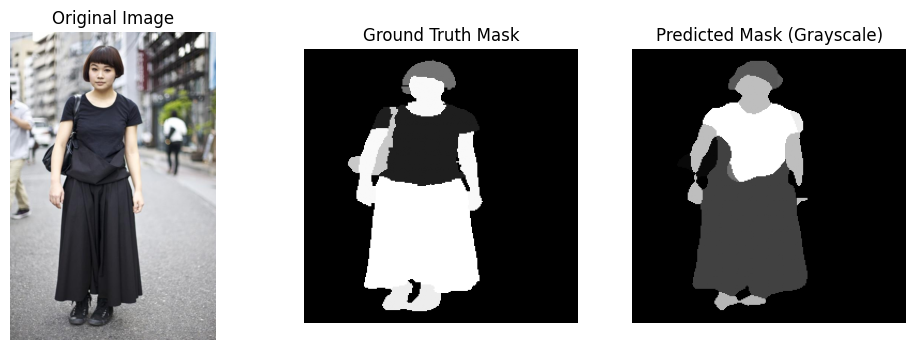

Class 1: IoU = 0.0000, Intersection = 0, Union = 116
Class 19: IoU = 0.5390, Intersection = 567, Union = 1052
Class 25: IoU = 0.4758, Intersection = 2469, Union = 5189
Class 31: IoU = 0.0000, Intersection = 0, Union = 2706
Class 39: IoU = 0.8102, Intersection = 683, Union = 843
Class 41: IoU = 0.2849, Intersection = 296, Union = 1039
Class 47: IoU = 0.0000, Intersection = 0, Union = 84
Class 48: IoU = 0.2699, Intersection = 1498, Union = 5550
Class 49: IoU = 0.0000, Intersection = 0, Union = 11
Class 51: IoU = 0.0000, Intersection = 0, Union = 2536
Class 54: IoU = 0.0000, Intersection = 0, Union = 271
Class 55: IoU = 0.0000, Intersection = 0, Union = 875
Mean IoU: 0.1983
Class 1: Dice = 0.0000, Intersection = 0, True Pixels = 116, Pred Pixels = 0
Class 19: Dice = 0.7004, Intersection = 567, True Pixels = 971, Pred Pixels = 648
Class 25: Dice = 0.6448, Intersection = 2469, True Pixels = 5154, Pred Pixels = 2504
Class 31: Dice = 0.0000, Intersection = 0, True Pixels = 0, Pred Pixels = 27

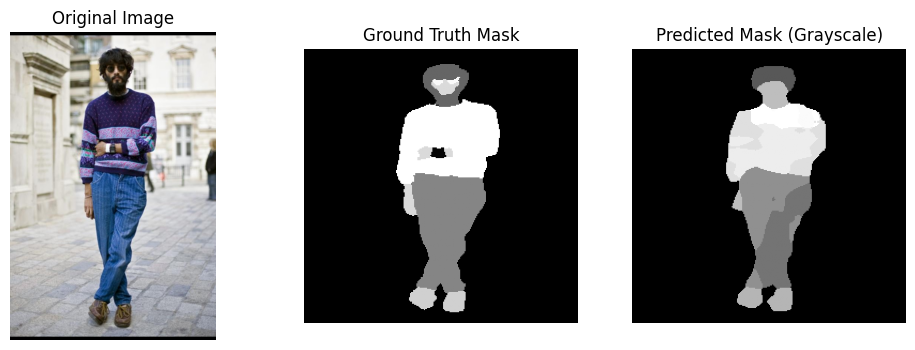

Class 3: IoU = 0.0000, Intersection = 0, Union = 330
Class 38: IoU = 0.1386, Intersection = 710, Union = 5122
Class 39: IoU = 0.7075, Intersection = 474, Union = 670
Class 41: IoU = 0.7998, Intersection = 1742, Union = 2178
Class 19: IoU = 0.5200, Intersection = 130, Union = 250
Class 51: IoU = 0.0000, Intersection = 0, Union = 1744
Class 55: IoU = 0.0000, Intersection = 0, Union = 2440
Class 31: IoU = 0.9276, Intersection = 7026, Union = 7574
Mean IoU: 0.3867
Class 3: Dice = 0.0000, Intersection = 0, True Pixels = 330, Pred Pixels = 0
Class 38: Dice = 0.2435, Intersection = 710, True Pixels = 5117, Pred Pixels = 715
Class 39: Dice = 0.8287, Intersection = 474, True Pixels = 659, Pred Pixels = 485
Class 41: Dice = 0.8888, Intersection = 1742, True Pixels = 1949, Pred Pixels = 1971
Class 19: Dice = 0.6842, Intersection = 130, True Pixels = 135, Pred Pixels = 245
Class 51: Dice = 0.0000, Intersection = 0, True Pixels = 0, Pred Pixels = 1744
Class 55: Dice = 0.0000, Intersection = 0, True

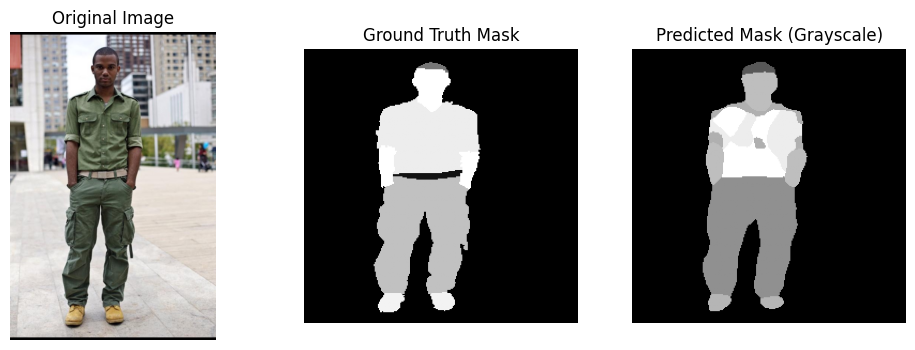

Class 2: IoU = 0.0000, Intersection = 0, Union = 529
Class 5: IoU = 0.0000, Intersection = 0, Union = 4524
Class 14: IoU = 0.4475, Intersection = 2773, Union = 6197
Class 19: IoU = 0.5289, Intersection = 256, Union = 484
Class 39: IoU = 0.8390, Intersection = 662, Union = 789
Class 41: IoU = 0.8019, Intersection = 3692, Union = 4604
Class 42: IoU = 0.0000, Intersection = 0, Union = 2774
Class 48: IoU = 0.0000, Intersection = 0, Union = 599
Class 51: IoU = 0.0000, Intersection = 0, Union = 724
Class 54: IoU = 0.0000, Intersection = 0, Union = 614
Class 55: IoU = 0.0000, Intersection = 0, Union = 2296
Mean IoU: 0.2379
Class 2: Dice = 0.0000, Intersection = 0, True Pixels = 529, Pred Pixels = 0
Class 5: Dice = 0.0000, Intersection = 0, True Pixels = 4524, Pred Pixels = 0
Class 14: Dice = 0.6183, Intersection = 2773, True Pixels = 5761, Pred Pixels = 3209
Class 19: Dice = 0.6919, Intersection = 256, True Pixels = 433, Pred Pixels = 307
Class 39: Dice = 0.9125, Intersection = 662, True Pixe

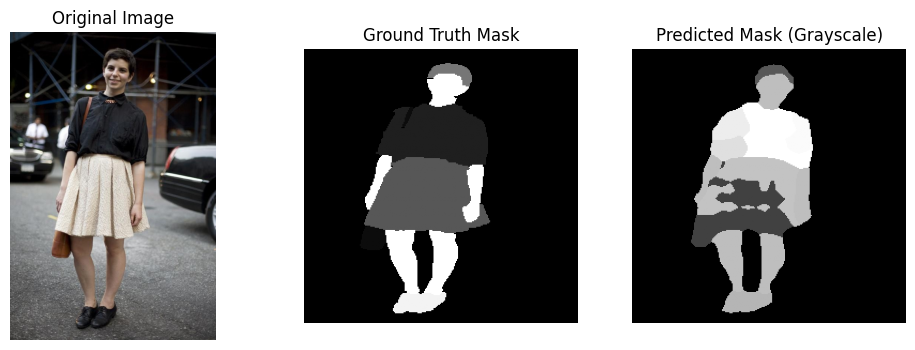

Class 2: IoU = 0.0000, Intersection = 0, Union = 686
Class 4: IoU = 0.0000, Intersection = 0, Union = 1131
Class 5: IoU = 0.0000, Intersection = 0, Union = 545
Class 7: IoU = 0.0000, Intersection = 0, Union = 72
Class 9: IoU = 0.0000, Intersection = 0, Union = 88
Class 19: IoU = 0.6107, Intersection = 1007, Union = 1649
Class 29: IoU = 0.0000, Intersection = 0, Union = 178
Class 31: IoU = 0.0000, Intersection = 0, Union = 11
Class 33: IoU = 0.0000, Intersection = 0, Union = 474
Class 39: IoU = 0.5949, Intersection = 627, Union = 1054
Class 40: IoU = 0.0000, Intersection = 0, Union = 2449
Class 41: IoU = 0.6604, Intersection = 2900, Union = 4391
Class 42: IoU = 0.0000, Intersection = 0, Union = 3322
Class 45: IoU = 0.0000, Intersection = 0, Union = 70
Class 47: IoU = 0.0000, Intersection = 0, Union = 190
Class 51: IoU = 0.2355, Intersection = 765, Union = 3249
Class 55: IoU = 0.0000, Intersection = 0, Union = 611
Mean IoU: 0.1236
Class 2: Dice = 0.0000, Intersection = 0, True Pixels = 6

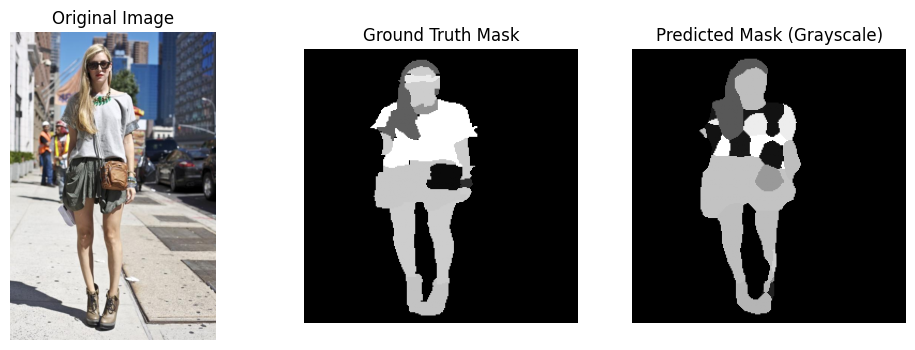

In [16]:
num_samples = min(5, len(os.listdir(TEST_IMAGES_DIR)))

for i in range(num_samples):
    image_path = os.path.join(TEST_IMAGES_DIR, sorted(os.listdir(TEST_IMAGES_DIR))[i])
    mask_path = os.path.join(TEST_MASKS_DIR, sorted(os.listdir(TEST_MASKS_DIR))[i])

    evaluate_single_image(model, image_path, mask_path, device, transform)



In [17]:
import os
import random
import cv2
import numpy as np

mask_dir = os.path.join(BASE_DIR, "dataset", "train", "masks")
# Path to the mask images folder
# mask_dir = "content/drive/My Drive/Clothing Segmentation/dataset/train/masks"

# Get list of all mask files
mask_files = [f for f in os.listdir(mask_dir) if f.endswith(".png")]

# Select 10 random masks (ensure there are at least 10 files)
sample_masks = random.sample(mask_files, min(10, len(mask_files)))

for mask_name in sample_masks:
    mask_path = os.path.join(mask_dir, mask_name)

    # Load mask
    mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

    # Check number of channels
    if len(mask.shape) == 2:
        print(f"{mask_name}: Single-channel (Grayscale)")
    elif len(mask.shape) == 3:
        print(f"{mask_name}: Multi-channel (Shape: {mask.shape}), Needs conversion to grayscale")

    # Get unique pixel values
    unique_values = np.unique(mask)
    print(f"Unique pixel values in {mask_name}: {unique_values}\n")


seg_0881.png: Single-channel (Grayscale)
Unique pixel values in seg_0881.png: [ 0  2 19 31 37 39 41 48]

seg_0627.png: Single-channel (Grayscale)
Unique pixel values in seg_0627.png: [ 0  9 19 33 37 39 41 42 55]

seg_0050.png: Single-channel (Grayscale)
Unique pixel values in seg_0050.png: [ 0  5 13 19 25 29 33 39 41]

seg_0523.png: Single-channel (Grayscale)
Unique pixel values in seg_0523.png: [ 0 19 31 38 39 41 44 46]

seg_0811.png: Single-channel (Grayscale)
Unique pixel values in seg_0811.png: [ 0  2  4  9 19 31 36 41 47 51]

seg_0713.png: Single-channel (Grayscale)
Unique pixel values in seg_0713.png: [ 0  1 19 31 33 39 41 51]

seg_0201.png: Single-channel (Grayscale)
Unique pixel values in seg_0201.png: [ 0  1  2  3  5 19 31 36 41 55]

seg_0551.png: Single-channel (Grayscale)
Unique pixel values in seg_0551.png: [ 0  3 19 31 37 39 41 46 55]

seg_0919.png: Single-channel (Grayscale)
Unique pixel values in seg_0919.png: [ 0  2 13 19 27 36 41]

seg_0458.png: Single-channel (Graysca